# <center>Прогнозирование обогащения золота</center>

## Описание проекта

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.


Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. 
Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. 
Также в тестовом наборе нет целевых признаков.


Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, необходимо проверить по инструкции их на корректность.

## Технологический процесс
Как золото получают из руды? 
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

### Опишем каждую стадию:
1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.


### Описание данных

#### Технологический процесс
- `Rougher feed` — исходное сырье
- `Rougher additions` (или reagent additions) — флотационные реагенты: `Xanthate`, `Sulphate`, `Depressant`
- `Xanthate**`— ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

#### Параметры этапов

- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

#### Наименование признаков

> Наименование признаков должно быть такое:
> `[этап].[тип_параметра].[название_параметра]`
>
>  Пример: `rougher.input.feed_ag`

#### Возможные значения для блока `[этап]`:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики


#### Возможные значения для блока `[тип_параметра]`:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики


### Расчёт эффективности
Необходимо смоделировать процесс восстановления золота из золотосодержащей руды.

Эффективность обогащения рассчитывается по формуле:


\begin{equation*}
Recovery = \frac{C\times(F-T)}{F\times(C-T)} \times 100\%
\end{equation*}
где:
- `C` — доля золота в концентрате после флотации/очистки;
- `F` — доля золота в сырье/концентрате до флотации/очистки;
- `T` — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


### Метрика качества

sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. 
Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.


Метрика sMAPE вычисляется так:

\begin{equation*}
    sMAPE = \frac{1}{N}\sum_{i=1}^N\frac{\mid{y_i-y'_i}\mid}{(\mid{y_i}\mid+\mid{y'_i}\mid)/2} \times 100\%
\end{equation*}
где:
- `y(i)` значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
- `y'(i)` значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

#### Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

#### Итоговая метрика складывается из двух величин:
\begin{equation*}
   sMAPE = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
\end{equation*}

### План работы
1. [Подготовка данных](#prep)
    1. [Загрузка и изучение файлов.](#open)
    2. [Проверка эффективности рассчета обогащения для признака rougher.output.recovery.](#recovey)
    3. [Анализ признаков, недоступных в тестовой выборке.](#test_features)
    4. [Предобработка данных.](#preprocessing)
2. [Исследовательский анализ данных](#eda)
    1. [Изучение изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.](#concentrate)
    2. [Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.](#feed_size)
    3. [Исследование суммарной концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Удаление аномалий.](#outliers)
3. [Построение моделей](#models)
    1. [Создание функции для вычисления итоговой sMAPE.](#smape)
    2. [Обучение разных моделей и оценка их качества кросс-валидацией.](#cross_val)
4. [Общий вывод](#output)

<a id='prep'></a>
## 1. Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score
sns.set_style('whitegrid')

<a id='open'></a>

In [ ]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')
dfs = {'full':full, 'train':train, 'test':test}

In [ ]:
class colors:
    header = '\033[95m'
    okblue = '\033[94m'
    okgreen = '\033[92m'
    warning = '\033[93m'
    fail = '\033[91m'
    end = '\033[0m'
    bold = '\033[1m'
    under = '\033[4m'

class Research:
    
    def __init__(self, df_dict):
        self.df_dict = df_dict   
        
    def __repr__(self):
        string = ', '.join(list(self.df_dict.keys()))
        return f'Объект содержит датасеты: {string}'

    def sum_nans(self, df=None, mass=True):
        if mass==True:
            for i in self.df_dict:
                len_nan = len(self.df_dict[i].isna().sum()[self.df_dict[i].isna().sum() > 0])
                all_nan = self.df_dict[i].isna().sum().sum()
                rows_nan = self.df_dict[i].shape[0] - self.df_dict[i].dropna().shape[0]
                print(f'Сумма пропусков в датасете {i} составляет: {all_nan}, число записей с пропусками: {rows_nan}, число столбцов с пропусками: {len_nan}')
        else:
            len_nan = len(df.isna().sum()[df.isna().sum() > 0])
            sum_nan = df.isna().sum().sum()
            rows_nan = df.shape[0] - df.dropna().shape[0]
            print(f'Сумма пропусков составляет: {sum_nan}, число записей с пропусками: {rows_nan}, число столбцов с пропусками: {len_nan}')
    
    def all_dupl(self):
        for i in self.df_dict:
            print(f'Число дубликатов в датасете {i} составляет:', self.df_dict[i].duplicated().sum())
    
    def demo(self, head=True):
        if head==True:
            for i in self.df_dict:
                display(self.df_dict[i].head(3))
                print(f'Датасет {colors.bold}{i}{colors.end}, число записей составляет: {self.df_dict[i].shape[0]}, число столбцов: {self.df_dict[i].shape[1]} ')
        else:
            for i in self.df_dict:
                print(f'Датасет {colors.bold}{i}{colors.end}, число записей составляет: {self.df_dict[i].shape[0]}, число столбцов: {self.df_dict[i].shape[1]} ')

In [ ]:
research = Research(dfs)

In [ ]:
print(research)

Объект содержит датасеты: full, train, test


In [ ]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [ ]:
research.demo()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


Датасет full, число записей составляет: 22716, число столбцов: 87 


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


Датасет train, число записей составляет: 16860, число столбцов: 87 


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


Датасет test, число записей составляет: 5856, число столбцов: 53 


Перед нами 3 датасета, один с исходными данными, 2 оставшихся - разделенные тренировочная и обучающая выборка. Всего 22716 записей, 87 столбцов с признаками. В тестовую выборку попали только 53 столбца. В данных есть пропуски, исследуем их количество:

In [ ]:
research.sum_nans()

Сумма пропусков в датасете full составляет: 36587, число записей с пропусками: 6622, число столбцов с пропусками: 85
Сумма пропусков в датасете train составляет: 30320, число записей с пропусками: 5843, число столбцов с пропусками: 85
Сумма пропусков в датасете test составляет: 2360, число записей с пропусками: 473, число столбцов с пропусками: 51


In [ ]:
full.isna().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_sol               2736
rougher.output.tail_au                2736
rougher.input.floatbank11_xanthate    2257
secondary_cleaner.output.tail_sol     2215
final.output.recovery                 1963
rougher.calculation.au_pb_ratio       1627
primary_cleaner.input.sulfate         1609
primary_cleaner.input.depressant      1546
dtype: int64

In [ ]:
train.isna().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

In [ ]:
test.isna().sum().sort_values(ascending=False).head(10)

rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

Изучим число дубликатов:

In [ ]:
research.all_dupl()

Число дубликатов в датасете full составляет: 0
Число дубликатов в датасете train составляет: 0
Число дубликатов в датасете test составляет: 0


<a id='recovery'></a>
### Проверим, что эффективность обогащения рассчитана правильно

Вычислим её на обучающей выборке для признака rougher.output.recovery и найдем MAE между расчётами и значением признака.

Сперва найдем признаки этапа флотации, содержащие данные с долей золота в отвальных хвостах, долю золота в сырье и долю золота в концентрате после флотации:

In [ ]:
rougher = train.columns[train.columns.str.contains('rougher.[A-z.]+_au$')].tolist()

In [ ]:
string = ', '.join(rougher)
print(f'Признаки этапа флотации для золота: {colors.header}{string}')

Признаки этапа флотации для золота: rougher.input.feed_au, rougher.output.concentrate_au, rougher.output.tail_au


Таким образом:

- `rougher.output.concentrate_au` — доля золота в концентрате после флотации/очистки;
- `rougher.input.feed_au` — доля золота в сырье/концентрате до флотации/очистки;
- `rougher.output.tail_au` — доля золота в отвальных хвостах после флотации/очистки.

Создадим датасет с фичами и целевым признаком:

In [ ]:
df_validation = train[[*rougher, 'rougher.output.recovery']].copy()

В данных было много пропусков, из-за них эффективность обогащение рассчитать не получится, изучим их количество и удалим:

In [ ]:
df_validation.isna().sum()

rougher.input.feed_au              83
rougher.output.concentrate_au      82
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64

In [ ]:
df_validation.dropna(subset=['rougher.output.recovery'], inplace=True)

Подставим значения в формулу и вычислим эффективность обогащения:

In [ ]:
def rate_rougher(row):
    t = row['rougher.output.tail_au']
    f = row['rougher.input.feed_au']
    c = row['rougher.output.concentrate_au']
    return (c*(f-t))/(f*(c-t)) * 100

In [ ]:
df_validation['recovery_calculate'] = df_validation.apply(rate_rougher, axis=1)

In [ ]:
mae = mean_absolute_error(df_validation['rougher.output.recovery'], df_validation['recovery_calculate'])
print(f'Средняя абсолютная ошибка между рассчетами составляет: {mae}')

Средняя абсолютная ошибка между рассчетами составляет: 9.444891926100695e-15


Средняя абсолютная ошибка очень низкая и стремится к нулю, что говорит о высокой точности расчета эффективности обогащения.

<a id='test_features'></a>
### Проанализируем признаки, недоступные в тестовой выборке

Первым делом получим даты из тестовой выборки и используем их для фильтрации исходных данных, пропущенные столбцы получим при помощи разницы множеств колонок двух выборок. Таким образом создадим два датасета: один будет состоять из пропущенных столбцов, а второй будет полностью скленным тестовым (в будущем, возможно, пригодятся все три):

In [ ]:
test_dates = test['date'].tolist()
missed_cols = full[full['date'].isin(test_dates)][set(train.columns).difference(set(test.columns))].copy()
missed_cols = missed_cols.reset_index(drop=True)
missed_cols['date'] = test['date']
full_test = test.copy()
full_test = full_test.merge(missed_cols, on='date')

Изучим, какие данные не попали в тестовую выборку:

In [ ]:
for k, i in enumerate(sorted(missed_cols.columns.tolist())):
    if i == 'date':
        continue
    print(f'{k}. {i}')

1. final.output.concentrate_ag
2. final.output.concentrate_au
3. final.output.concentrate_pb
4. final.output.concentrate_sol
5. final.output.recovery
6. final.output.tail_ag
7. final.output.tail_au
8. final.output.tail_pb
9. final.output.tail_sol
10. primary_cleaner.output.concentrate_ag
11. primary_cleaner.output.concentrate_au
12. primary_cleaner.output.concentrate_pb
13. primary_cleaner.output.concentrate_sol
14. primary_cleaner.output.tail_ag
15. primary_cleaner.output.tail_au
16. primary_cleaner.output.tail_pb
17. primary_cleaner.output.tail_sol
18. rougher.calculation.au_pb_ratio
19. rougher.calculation.floatbank10_sulfate_to_au_feed
20. rougher.calculation.floatbank11_sulfate_to_au_feed
21. rougher.calculation.sulfate_to_au_concentrate
22. rougher.output.concentrate_ag
23. rougher.output.concentrate_au
24. rougher.output.concentrate_pb
25. rougher.output.concentrate_sol
26. rougher.output.recovery
27. rougher.output.tail_ag
28. rougher.output.tail_au
29. rougher.output.tail_pb
3

В тестовую выборку не попали данные со всех этапов с долей элементов в концентратах, отвальных хвостах, также рассчеты эффективности обогащения и др. 

<a id='preprocessing'></a>
### Предобработка данных

Исходя из условия, мы знаем, что данные индексируются датой и временем получения информации (признак date) и соседние по времени параметры часто похожи. Поскольку, данные упорядочены по дате, можно заполнить пропуск предыдщим известным значением. Рассчитаем среднее значение по всем столбцам и вычислим среднее от средних, чтобы посмотреть, насколько сильно может сместить значения заполнение пропусков таким образом. Предварительно добавим новые выборки в словарь с датасетами и изучим пропуски:

In [ ]:
research.df_dict['missed_cols'] = missed_cols
research.df_dict['full_test'] = full_test

In [ ]:
research.sum_nans()

Сумма пропусков в датасете full составляет: 36587, число записей с пропусками: 6622, число столбцов с пропусками: 85
Сумма пропусков в датасете train составляет: 30320, число записей с пропусками: 5843, число столбцов с пропусками: 85
Сумма пропусков в датасете test составляет: 2360, число записей с пропусками: 473, число столбцов с пропусками: 51
Сумма пропусков в датасете missed_cols составляет: 3907, число записей с пропусками: 745, число столбцов с пропусками: 34
Сумма пропусков в датасете full_test составляет: 6267, число записей с пропусками: 779, число столбцов с пропусками: 85


Получим оценки средних до и после заполнения:

In [ ]:
def means(df):
    global means_val
    means_val = []
    for i in df.columns:
        try:
            means_val.append(np.mean(df[i]))
        except:
            pass
    return np.mean(means_val)

In [ ]:
data_values = {k:[means(i), means(i.fillna(method='ffill'))] for k,i in research.df_dict.items()}

In [ ]:
eval_means = pd.DataFrame(data=data_values, index=['before','after']).round(2)
eval_means.loc['ratio'] = (((1 - eval_means.loc['before'] / eval_means.loc['after']))
                           .map(lambda x: '{:.1%}'.format(x)))
display(eval_means)

,full,train,test,missed_cols,full_test
before,-73070,-9.14,79.64,-717701,-283694
after,-73767.6,-9.89,79.35,-723845,-286123
ratio,0.9%,7.6%,-0.4%,0.8%,0.8%


Разница в оценках средних после заполнения везде небольшая и для 4 выборок не превышает 1%, только для датасета `train` составляет 7.6%. Тем не менее, больше всего привлекает внимание то, что оценка среднего для потерянных тестовых данных составляет -717701, среднее датасета `train` больше в 80000 раз, это почти наверняка говорит об аномалиях в данных. Пока убедимся что, такое отклонение не является результатом ошибки в коде, и сравним оценку среднего `full` со склеенными `train` и `test`:

In [ ]:
print('Оценка среднего для склееных выборок train и full_test составляет:', means(pd.concat([train, full_test], sort=False)))

Оценка среднего для склееных выборок train и full_test составляет: -73070.03160923878


Отсюда можно сделать вывод, что датасет `full_test` собран правильно.

Изучим аномалии в данных:

In [ ]:
means(missed_cols)
data_out = [[missed_cols.columns[i], means_val[i]] for i in range(len(means_val))]
data_out = pd.DataFrame(data=data_out, columns=['col_name', 'means'])
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(data_out.sort_values(by='means', ascending=False).head())
display(data_out.sort_values(by='means', ascending=True).head())

,col_name,means
30,rougher.calculation.floatbank11_sulfate_to_au_...,3094.287755
22,rougher.calculation.floatbank10_sulfate_to_au_...,2910.018530
13,rougher.output.recovery,84.918269
27,final.output.recovery,68.111372
26,final.output.concentrate_au,41.535937


,col_name,means
17,rougher.calculation.sulfate_to_au_concentrate,-2.440830e+07
19,rougher.output.tail_pb,5.853678e-01
25,rougher.output.tail_au,1.977029e+00
12,rougher.calculation.au_pb_ratio,2.552811e+00
21,final.output.tail_pb,2.853626e+00


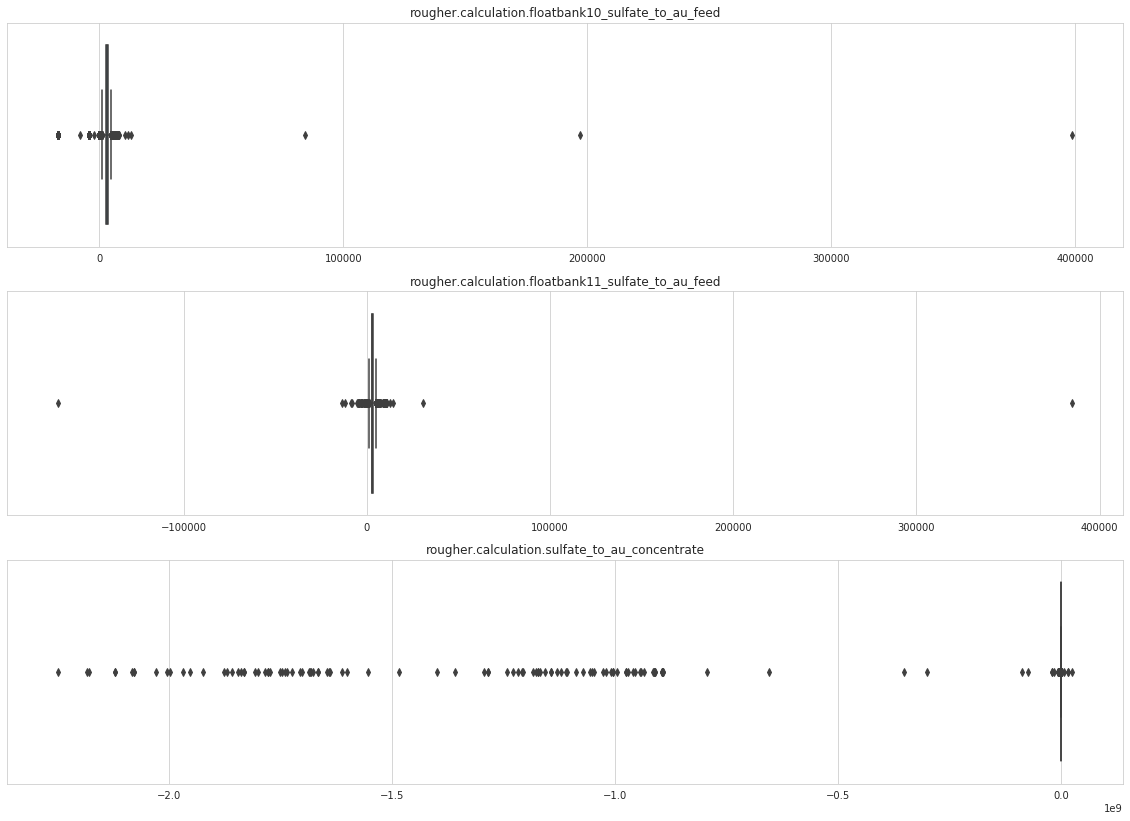

In [ ]:
plt.subplots(figsize=(20, 14))
plt.subplot(3,1,1)
sns.boxplot(missed_cols['rougher.calculation.floatbank10_sulfate_to_au_feed'])
plt.title('rougher.calculation.floatbank10_sulfate_to_au_feed')
plt.xlabel('')
plt.subplot(3,1,2)
sns.boxplot(missed_cols['rougher.calculation.floatbank11_sulfate_to_au_feed'])
plt.xlabel('')
plt.title('rougher.calculation.floatbank11_sulfate_to_au_feed')
plt.subplot(3,1,3)
sns.boxplot(missed_cols['rougher.calculation.sulfate_to_au_concentrate'])
plt.xlabel('')
plt.title('rougher.calculation.sulfate_to_au_concentrate')
plt.show()

В данных действительно присутствуют очевидные выбросы, чтобы не потерять полноту в данных, сейчас не будем удалять их, а попробуем не использовать их на этапе построения модели.

Заполним пропуски в 4х датасетах. Full оставим нетронутым, на случай, если понадобятся данные в исходном виде:

In [ ]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
missed_cols.fillna(method='ffill', inplace=True)
full_test.fillna(method='ffill', inplace=True)

In [ ]:
research.sum_nans()

Сумма пропусков в датасете full составляет: 36587, число записей с пропусками: 6622, число столбцов с пропусками: 85
Сумма пропусков в датасете train составляет: 0, число записей с пропусками: 0, число столбцов с пропусками: 0
Сумма пропусков в датасете test составляет: 0, число записей с пропусками: 0, число столбцов с пропусками: 0
Сумма пропусков в датасете missed_cols составляет: 0, число записей с пропусками: 0, число столбцов с пропусками: 0
Сумма пропусков в датасете full_test составляет: 0, число записей с пропусками: 0, число столбцов с пропусками: 0


## Вывод

На этом этапе были загружены и изучены 3 датасета (исходный, тренировочный и обучающий), в данных обнаружены пропуски, дубликаты отсутствуют. Была проверена точность расчета эффективности обогащения для руды - средняя абсолютная ошибка стремится к нулю; были проанализированы признаки, недоступные в тестовой выборке - ими оказались данные со всех этапов с долей элементов в концентратах, отвальных хвостах и др.; тестовый датасет был полностью восстановлен, также были заполнены пропуски соседними значениями и найдены аномалии в данных.

<a id='eda'></a>
## 2. Проанализируем данные

<a id='concentrate'></a>
### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Для начала выделим столбцы с данными о концентратах:

In [ ]:
def search(string):
    return full.columns[full.columns.str.contains(string)]

In [ ]:
clean_cols = (sorted(search('[A-z.]+concentrate_[^sol]|feed_[^solr]').tolist(), reverse=True))
print('Названия столбцов с данными о концентратах:')
print('\n'.join(clean_cols))

Названия столбцов с данными о концентратах:
rougher.output.concentrate_pb
rougher.output.concentrate_au
rougher.output.concentrate_ag
rougher.input.feed_pb
rougher.input.feed_au
rougher.input.feed_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_au
final.output.concentrate_ag


Построим гистограммы плотности распределения:

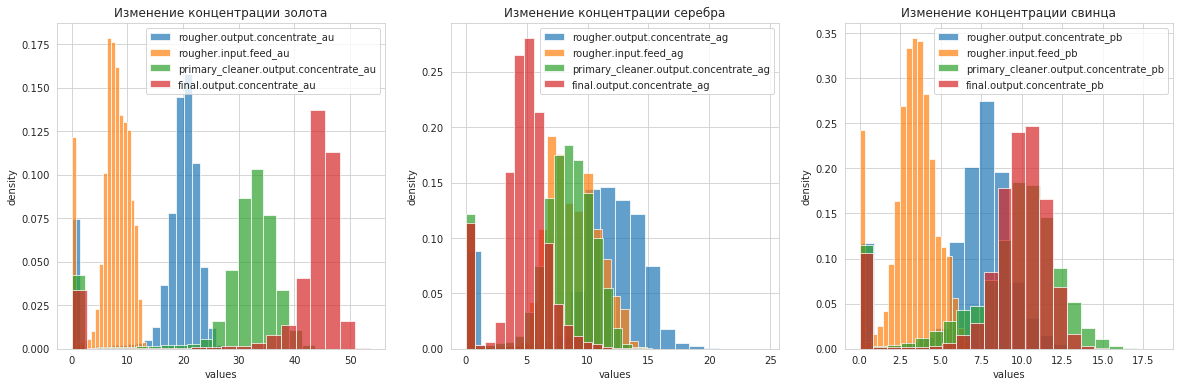

In [ ]:
def graph(df, col, title, label):
        plt.hist(df[col],bins=20, alpha=0.7, label=label, density=True)
        plt.legend()
        plt.xlabel('values')
        plt.ylabel('density')
        plt.title(title)
plt.subplots(figsize=(20,6))
plt.subplot(1,3,1)
for i in clean_cols:
    if "_au" in i:
        graph(full,i, 'Изменение концентрации золота', i)
plt.subplot(1,3,2)
for i in clean_cols:
    if "_ag" in i:
        graph(full, i, 'Изменение концентрации серебра', i)
plt.subplot(1,3,3)        
for i in clean_cols:
    if "_pb" in i:
        graph(full, i,'Изменение концентрации свинца', i)
plt.show()

По гистограммам можно отметить, что в целом распределения имеют похожую форму, при этом доля золота и свинца растет к финальному концентрату, а для серебра, наоборот, снижается. Изучим средние:

In [ ]:
def concentrate(metall):
    data_test = full[clean_cols].describe()
    return data_test[data_test.columns[data_test.columns.str.contains(metall)]].T['mean']

In [ ]:
concentrate('_au')

rougher.output.concentrate_au            17.879538
rougher.input.feed_au                     7.565838
primary_cleaner.output.concentrate_au    29.212289
final.output.concentrate_au              40.001172
Name: mean, dtype: float64

In [ ]:
concentrate('_ag')

rougher.output.concentrate_ag            10.874484
rougher.input.feed_ag                     8.065715
primary_cleaner.output.concentrate_ag     7.691652
final.output.concentrate_ag               4.781559
Name: mean, dtype: float64

In [ ]:
concentrate('_pb')

rougher.output.concentrate_pb            6.900646
rougher.input.feed_pb                    3.305676
primary_cleaner.output.concentrate_pb    8.921110
final.output.concentrate_pb              9.095308
Name: mean, dtype: float64

Таким образом, в финальном концентрате средняя доля золота выросла в 5.7 раза по сравнению с изначальным, для свинца в 3 раза, а для серебра уменьишалсь в 1.7 раза.

<a id='feed_size'></a>
### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

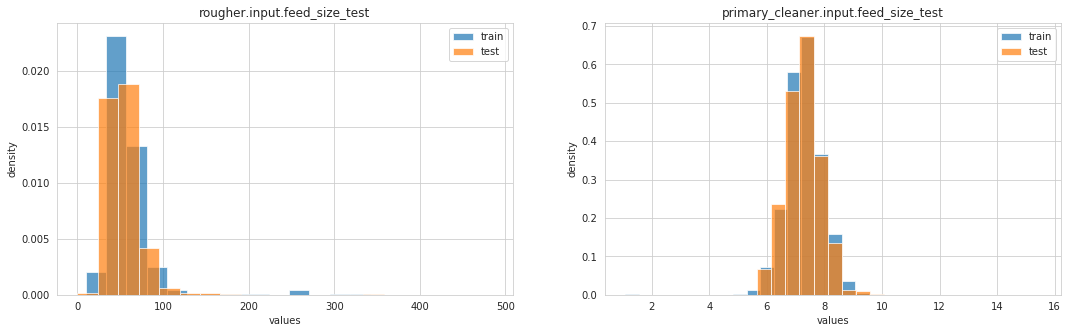

In [ ]:
plt.subplots(figsize=(18, 5))
plt.subplot(1,2,1)  
graph(train, 'rougher.input.feed_size', 'rougher.input.feed_size_train', 'train')
graph(test, 'rougher.input.feed_size', 'rougher.input.feed_size_test', 'test')
plt.subplot(1,2,2) 
graph(train, 'primary_cleaner.input.feed_size', 'primary_cleaner.input.feed_size_train', 'train')
graph(test, 'primary_cleaner.input.feed_size', 'primary_cleaner.input.feed_size_test', 'test')
plt.show()

Визуально распределения на двух графиках имеют очень похожую форму и принимают одинаковые значения, с разной плотностью для разных выборок. Изучим описательные статистики:

In [ ]:
descr = (train[[*search('feed_size')]].describe().round(2).add_suffix('_train')
         .join(test[[*search('feed_size')]].describe().round(2).add_suffix('_test')))
descr = descr[sorted(descr.columns, reverse=True)]
display(descr)

,rougher.input.feed_size_train,rougher.input.feed_size_test,primary_cleaner.input.feed_size_train,primary_cleaner.input.feed_size_test
count,16860.00,5856.00,16860.00,5856.00
mean,60.19,55.90,7.30,7.26
std,30.52,22.71,0.62,0.61
min,9.66,0.05,1.08,5.65
25%,47.55,43.85,6.94,6.89
50%,54.07,49.96,7.29,7.26
75%,65.40,61.63,7.70,7.65
max,484.97,477.45,10.47,15.50


Средние практически одинаковы для двух выборок, значения на Q1-Q3 также очень похожи. Отсюда можно сделать вывод, что у распределений нет сильных различий.

<a id='outliers'></a>
### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Аномальные значения удалим.

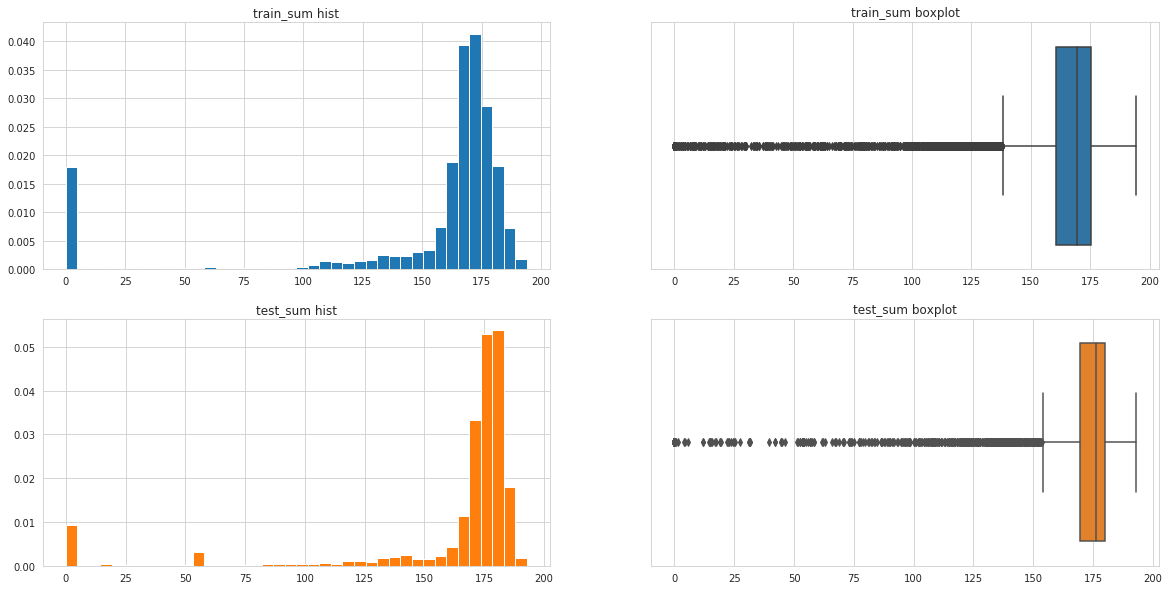

In [ ]:
plt.subplots(figsize=(20, 10))
concentrate_cols = [*search('[A-z.]+concentrate_au|feed_au'),
                    *search('[A-z.]+concentrate_ag|feed_ag'),
                    *search('[A-z.]+concentrate_pb|feed_pb')]

train_sum = train[concentrate_cols].sum(axis=1)
test_sum = full_test[concentrate_cols].sum(axis=1)
plt.subplot(2,2,1)
plt.hist(train_sum,density=True, bins=40)
plt.title('train_sum hist')
plt.subplot(2,2,2)
sns.boxplot(train_sum)
plt.title('train_sum boxplot')
plt.subplot(2,2,3)
plt.hist(test_sum,density=True, bins=40, color=['C1'])
plt.title('test_sum hist')
plt.subplot(2,2,4)
sns.boxplot(test_sum, palette=['C1'])
plt.title('test_sum boxplot')
plt.show()

На диаграммах рахмаха для двух выборок можно заметить большое число выбросов, изучим их количество и удалим:

In [ ]:
train['sum_concentrate'] = train_sum
full_test['sum_concentrate'] = test_sum
test['sum_concentrate'] = test_sum
def outburst(df, col):
    boxplot = plt.boxplot(df[col])
    global outliers
    outliers = list(boxplot["fliers"][0].get_data()[1])
    print(f"Количество выбросов в {col}:", len(outliers))
    plt.close()

In [ ]:
outburst(train, 'sum_concentrate')
train_out = outliers
outburst(full_test, 'sum_concentrate')
test_out = outliers

Количество выбросов в sum_concentrate: 2733
Количество выбросов в sum_concentrate: 837


In [ ]:
train = train[~train['sum_concentrate'].isin(train_out)].copy()
full_test = full_test[~full_test['sum_concentrate'].isin(test_out)].copy()
test = test[~test['sum_concentrate'].isin(test_out)].copy()

train = train.drop('sum_concentrate', axis=1).reset_index(drop=True)
full_test = full_test.drop('sum_concentrate', axis=1).reset_index(drop=True)
test = test.drop('sum_concentrate', axis=1).reset_index(drop=True)

### Вывод

На этом этапе был проведен исследовательский анализ данных: изучено изменение концентрации золота, серебра и свинца на различных этапах очистки (в финальном концентрате средняя доля золота выросла в 5.7 раза по сравнению с изначальным, для свинца в 3 раза, а для серебра уменьишалсь в 1.7 раза.), было изучено распределение гранул сырья в обучающей и тестовой выборках - различий нет (распределения имеют очень похожую форму и принимают одинаковые значения, с разной плотностью; средние практически одинаковы, значения на Q1-Q3 также очень похожи). Также была исследована суммарная концентрация всех веществ на всех этапах и удалены выбросы.

<a id='models'></a>
## 3. Построение моделей
<a id='smape'></a>
### Напишем функцию для вычисления итоговой sMAPE:


In [ ]:
def total_smape(rougher_target, rougher_pred, final_target, final_pred):
    def smape(col_target, col_pred):
        num = np.absolute(col_target - col_pred) 
        denum = (np.absolute(col_target) + np.absolute(col_pred)) / 2
        return (num/denum).sum() / len(col_target) * 100
    return round(0.25 * smape(rougher_target, rougher_pred) + 0.75 * smape(final_target, final_pred),2)

Создадим модель линейной регрессии и случайного леса, в качестве признаков будем использовать все доступные из тестовой выборки. При помощи кросс-валидации определим лучшую модель:

In [ ]:
lr = LinearRegression(normalize=True)
rf = RandomForestRegressor(n_estimators=5, max_depth=6, random_state=42)

features_train = train[test.columns].drop(['date'], axis=1)
features_test = test.drop(['date'], axis=1)
target_train = train[['rougher.output.recovery', 'final.output.recovery']]
target_test = full_test[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
%%time
cross_val_features = pd.concat([features_train, features_test])
cross_val_target_1 = pd.concat([target_train['rougher.output.recovery'], target_test['rougher.output.recovery']])
cross_val_target_2 = pd.concat([target_train['final.output.recovery'], target_test['final.output.recovery']])

def cross_val(model_1, model_2, cross_val_features):
    for i in [model_1, model_2]:
        score_rough = np.mean(cross_val_score(i, cross_val_features, cross_val_target_1, cv=5, scoring='r2'))
        score_final = np.mean(cross_val_score(i, cross_val_features, cross_val_target_2, cv=5, scoring='r2'))
        print(f'Кросс-валидация для {type(i)}: \nr2_rougher.output.recovery = {score_rough} \nr2_final.output.recovery {score_final}')
        
cross_val(lr, rf, cross_val_features)

Кросс-валидация для <class 'sklearn.linear_model.base.LinearRegression'>: 
r2_rougher.output.recovery = -0.2644287394625464 
r2_final.output.recovery -0.029198460037287054
Кросс-валидация для <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 
r2_rougher.output.recovery = -0.38200154142147624 
r2_final.output.recovery -0.1509366811124986
CPU times: user 21.3 s, sys: 3.58 s, total: 24.9 s
Wall time: 25.3 s


Результаты тестирования случайного леса хуже, чем у линейной регрессии, не говоря о том, что случайный лес выполняет обработку дольше. Для проверки на тестовой выборке будем использовать линейную регрессию:

In [ ]:
lr.fit(features_train, target_train)
lr_predict = lr.predict(features_test)

In [ ]:
def metrics(col0, col1, preds0, preds1):
    mae_0 = mean_absolute_error(target_test[col0], preds0)
    mae_1 = mean_absolute_error(target_test[col1], preds1)
    r2_0 = r2_score(target_test[col0], preds0)
    r2_1 = r2_score(target_test[col1], preds1)
    print('Метрики качества модели:')
    print(f'MAE для {col0}: {mae_0}')
    print(f'R2 для {col0}: {r2_0}')
    print(f'MAE для {col1}: {mae_1}')
    print(f'R2 для {col1}: {r2_1}')

In [ ]:
metrics('rougher.output.recovery', 'final.output.recovery', lr_predict[:,0], lr_predict[:,1])

Метрики качества модели:
MAE для rougher.output.recovery: 4.643931528715245
R2 для rougher.output.recovery: -0.33370925238837246
MAE для final.output.recovery: 5.282422318412536
R2 для final.output.recovery: -0.08047435111399959


Создадим константную модель и посчитаем её среднюю абсолютную процентную ошибку. Затем рассчитаем её для модели линейной регрессии и сравним их:

In [ ]:
constant_rougher_predict = pd.Series(target_train['rougher.output.recovery'].median(), range(len(target_test)))
constant_final_predict = pd.Series(target_train['final.output.recovery'].median(), range(len(target_test)))

constant_smape = total_smape(target_test['rougher.output.recovery']
            , constant_rougher_predict, 
            target_test['final.output.recovery'], constant_final_predict)

In [ ]:
lr_smape = total_smape(target_test['rougher.output.recovery'], lr_predict[:,0], 
                       target_test['final.output.recovery'], lr_predict[:,1])

print(f'Итоговая sMAPE для линейной регрессии составляет: {lr_smape}%, для контантной модели: {constant_smape}%')

Итоговая sMAPE для линейной регрессии составляет: 7.27%, для контантной модели: 7.16%


Получается, что среднее абсолютное процентное отклонение для модели линейной регрессии выше, чем для случайной. Посмотрим, как распределены предсказанные данные относительно реальных:

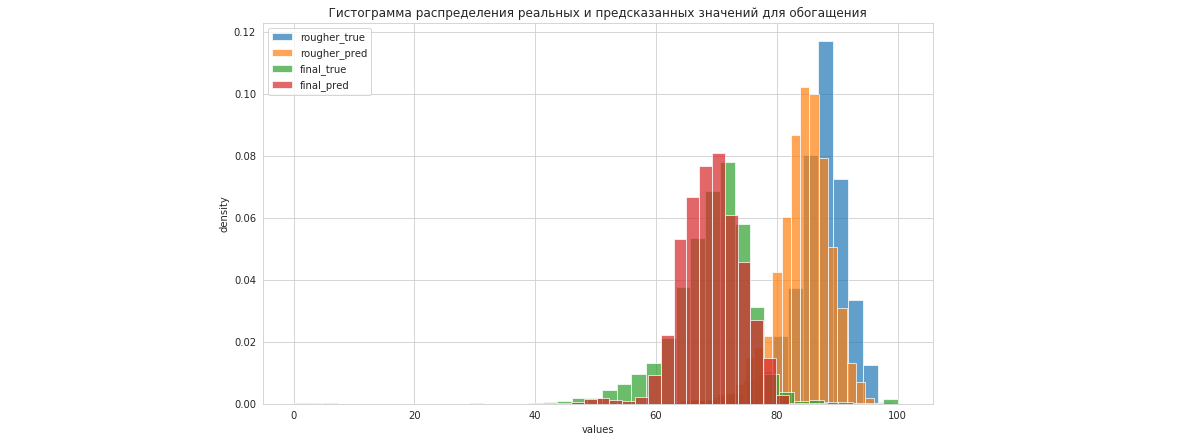

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(target_test['rougher.output.recovery'], bins=40, alpha=0.7, label='rougher_true', density=True)
plt.hist(lr_predict[:,0], bins=40, alpha=0.7, density=True, label='rougher_pred')
plt.hist(target_test['final.output.recovery'], bins=40, alpha=0.7, density=True, label='final_true')
plt.hist(lr_predict[:,1], bins=40, alpha=0.7, density=True, label='final_pred')
plt.title(('Гистограмма распределения реальных и предсказанных значений для обогащения').center(240))
plt.xlabel('values')
plt.ylabel('density')
plt.legend()
plt.show()

Видно, что для признака `rougher.output.recovery`, предсказания смещены немного влево, хоть и распределения имеют похожую форму. Для признака  `final.output.recovery` распределения в основном центрированы, но у некоторых значений заметны большие различия в плотности.

Попробуем повысить точность предсказаний, для этого произведем отбор признаков. Выполнять предсказания будем при помощи модели линейной регрессии из-за скорости расчетов, в качестве результата будем записывать значение метрик R2 для целевых признаков. Отсортируем признаки по важности и будем перебирать их, постепенно увеличивая количество:

In [ ]:
lr = LinearRegression(normalize=True)

def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return fs

fs_1 = select_features(features_train, target_train['rougher.output.recovery'], features_test)
fs_2 = select_features(features_train, target_train['final.output.recovery'], features_test)
fs_list_1 = pd.Series(fs_1.scores_).to_frame('select')
fs_list_1['cols'] = features_train.columns

fs_list_2 = pd.Series(fs_2.scores_).to_frame('select')
fs_list_2['cols'] = features_train.columns

def model_columns(num, fs_list):
    return fs_list.sort_values(by=['select'], ascending=False).reset_index(drop=True).iloc[:num]['cols'].tolist()
def scoring(fs_list):
    scores = []
    for i in range(len(fs_list)):
        if i < 10:
            continue
        elif i == 40:
            break
        features_train = train[model_columns(i, fs_list)]
        features_test = full_test[model_columns(i, fs_list)]
        lr.fit(features_train, target_train)
        preds = lr.predict(features_test)
        scores.append([i, r2_score(target_test['rougher.output.recovery'],preds[:, 0]),
                      r2_score(target_test['final.output.recovery'],preds[:, 1])]) 
        
    return scores

Получим оптимальный набор столбцов, при котором метрики достигают максимальных значений:

In [ ]:
%%time
scores_df = pd.DataFrame(data=scoring(fs_list_1), columns=['num_fs1', 'r2_rough', 'r2_final']).set_index('num_fs1')
scores_df['max'] = scores_df.sum(axis=1)
best_score_r = scores_df[scores_df['max'] == scores_df.max()['max']].drop('max',axis=1)
display(best_score_r)
scores_df = pd.DataFrame(data=scoring(fs_list_2), columns=['num_fs2', 'r2_rough', 'r2_final']).set_index('num_fs2')
scores_df['max'] = scores_df.sum(axis=1)
best_score_f = scores_df[scores_df['max'] == scores_df.max()['max']].drop('max',axis=1)
display(best_score_f)

,r2_rough,r2_final
num_fs1,,
13,0.101561,0.042704


,r2_rough,r2_final
num_fs2,,
15,0.147298,0.041039


CPU times: user 6.53 s, sys: 6.45 s, total: 13 s
Wall time: 13 s


Изучим признаки:

In [ ]:
for k,i in enumerate((set(model_columns(15, fs_list_2)).union(set(model_columns(13, fs_list_1))))):
    print(f'{k}. {i}')

0. secondary_cleaner.state.floatbank3_a_air
1. secondary_cleaner.state.floatbank5_b_air
2. secondary_cleaner.state.floatbank5_a_air
3. rougher.state.floatbank10_c_air
4. rougher.state.floatbank10_a_level
5. secondary_cleaner.state.floatbank4_a_air
6. rougher.input.feed_pb
7. secondary_cleaner.state.floatbank4_b_air
8. rougher.input.feed_ag
9. primary_cleaner.input.sulfate
10. primary_cleaner.input.xanthate
11. rougher.input.floatbank11_xanthate
12. rougher.input.floatbank10_xanthate
13. rougher.input.feed_sol
14. rougher.input.feed_au
15. rougher.state.floatbank10_d_air
16. rougher.input.feed_rate
17. rougher.state.floatbank10_a_air


Создадим набор признаков из объединенных множеств:

In [ ]:
features_tr = train[(set(model_columns(15, fs_list_2)).union(set(model_columns(13, fs_list_1))))]
features_ts = test[(set(model_columns(15, fs_list_2)).union(set(model_columns(13, fs_list_1))))]
cross_val_features = pd.concat([features_tr, features_ts])

Создадим модель Ridge регрессии и попробуем перебрать параметры alpha для поиска оптимального:

In [ ]:
%%time
ridge=Ridge()
params = {'alpha':[*range(9000,14000,500)]}
grid = GridSearchCV(ridge, params, cv=5)
grid.fit(cross_val_features, cross_val_target_1)
print('rougher.output.recovery:',grid.best_score_, grid.best_params_)
grid.fit(cross_val_features, cross_val_target_2)
print('final.output.recovery:', grid.best_score_, grid.best_params_)

rougher.output.recovery: 0.013832288204070835 {'alpha': 12500}
final.output.recovery: 0.12392783122327068 {'alpha': 10000}
CPU times: user 4.41 s, sys: 4.6 s, total: 9.01 s
Wall time: 9 s


Будем использовать усредненную alpha

<a id='cross_val'></a>
### Проведение кросс-валидации для моделей Ridge-регрессии и линейной регрессии для 5 фолдов:

In [ ]:
%%time
ridge=Ridge(alpha=11250)
cross_val(lr, ridge, cross_val_features)

Кросс-валидация для <class 'sklearn.linear_model.base.LinearRegression'>: 
r2_rougher.output.recovery = -0.04342502214738806 
r2_final.output.recovery 0.09381433441286147
Кросс-валидация для <class 'sklearn.linear_model.ridge.Ridge'>: 
r2_rougher.output.recovery = 0.013756539010961476 
r2_final.output.recovery 0.12386984924634192
CPU times: user 1.26 s, sys: 1.33 s, total: 2.6 s
Wall time: 2.6 s


Метрики модели Ridge выше, будем использовать её для проверки на тестовой выборке: 

In [ ]:
ridge.fit(features_tr, target_train)
preds = ridge.predict(features_ts)

In [ ]:
metrics('rougher.output.recovery', 'final.output.recovery', preds[:, 0], preds[:,1])

Метрики качества модели:
MAE для rougher.output.recovery: 3.4559311022623094
R2 для rougher.output.recovery: 0.15379647853759693
MAE для final.output.recovery: 4.822617571655102
R2 для final.output.recovery: 0.06481878507881855


In [ ]:
ridge_smape = total_smape(target_test['rougher.output.recovery'], preds[:,0], 
                       target_test['final.output.recovery'], preds[:,1])
print(f'Итоговая sMAPE для Ridge-регрессии составляет: {ridge_smape}%, для случайной модели: {constant_smape}%')

Итоговая sMAPE для Ridge-регрессии составляет: 6.41%, для случайной модели: 7.16%


Визуализируем реальные и предсказанные значения:

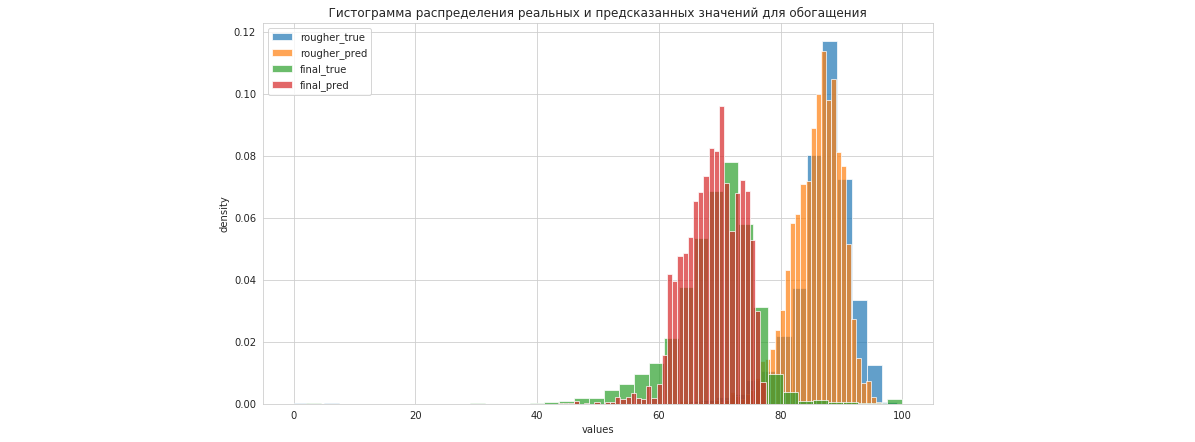

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(target_test['rougher.output.recovery'], bins=40, alpha=0.7, label='rougher_true', density=True)
plt.hist(preds[:, 0], bins=40, alpha=0.7, density=True, label='rougher_pred')
plt.hist(target_test['final.output.recovery'], bins=40, alpha=0.7, density=True, label='final_true')
plt.hist(preds[:, 1], bins=40, alpha=0.7, density=True, label='final_pred')
plt.title(('Гистограмма распределения реальных и предсказанных значений для обогащения').center(240))
plt.xlabel('values')
plt.ylabel('density')
plt.legend()
plt.show()

Теперь предсказания менее смещены относительно реальных значений, в сравнении с предсказаниями ненастроенной линейной регресиией.

### Вывод

На этом этапе были созданы несколько моделей линейной регрессии, случайного леса и Ridge-регресии, был произведен отбор признаков для предсказания, а при помощи кросс-валидации была выбрана самая эффективная модель, которой оказалась Ridge.

Метрики качества:
- MAE для rougher.output.recovery: 3.46
- R2 для rougher.output.recovery: 0.15
- MAE для final.output.recovery: 4.82
- R2 для final.output.recovery: 0.07
- итоговая sMAPE: 6.41%

<a id='output'></a>
## Общий вывод

Были изучены датасеты с информацией об обогащении и очистке золота, обнаруженные пропуски заполнены и удалены аномалии. Была проверена точность расчета эффективности обогащения для руды - средняя абсолютная ошибка стремится к нулю; были проанализированы признаки, недоступные в тестовой выборке - ими оказались данные со всех этапов с долей элементов в концентратах, отвальных хвостах и др.

Был проведен исследовательский анализ данных: 
- в финальном концентрате средняя доля золота выросла в 5.7 раза по сравнению с изначальным, для свинца в 3 раза, а для серебра уменьишалсь в 1.7 раза, 
- распределения гранул сырья в двух выборках имеют очень похожую форму и принимают одинаковые значения, с разной плотностью; средние практически одинаковы, значения на Q1-Q3 также очень похожи.

Были созданы и протестированы несколько моделей линейной регрессии, случайного леса и Ridge-регресии, был произведен отбор признаков для предсказания, а при помощи кросс-валидации была выбрана самая эффективная модель, которой оказалась Ridge.


Метрики качества:
- MAE для rougher.output.recovery: 3.46
- R2 для rougher.output.recovery: 0.15
- MAE для final.output.recovery: 4.82
- R2 для final.output.recovery: 0.07
- итоговая sMAPE: 6.41%